In [9]:
# Cell 1 - Imports
import torch
import torchvision
import numpy as np
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from PIL import Image, ImageDraw, ImageFont
import time
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt
from IPython.display import display

In [10]:
# Cell 2 - Define the ObjectDetector Class
class ObjectDetector:
    def __init__(self, confidence_threshold: float = 0.5):
        # Load pre-trained model with updated weights
        self.weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=self.weights)
        self.model.eval()
        self.confidence_threshold = confidence_threshold
        self.COCO_CLASSES = self.weights.meta['categories']

    # Cell 3 - Process Image Method
    def process_image(self, image_path: str) -> Dict[str, Any]:
        """Process image and return comprehensive detection results."""
        start_time = time.time()
        
        # Detect objects
        detections = self.detect_objects(image_path)
        
        # Calculate statistics
        stats = self.calculate_statistics(detections)
        
        # Calculate processing time
        processing_time = time.time() - start_time
        
        return {
            "detections": detections,
            "statistics": stats,
            "processing_time": processing_time,
            "image_metadata": self.get_image_metadata(image_path)
        }
    
    # Cell 4 - Detect Objects Method
    def detect_objects(self, image_path: str) -> List[Dict[str, Any]]:
        """Detect objects in an image with enhanced information."""
        try:
            # Load and preprocess image
            image = Image.open(image_path).convert("RGB")
            transform = self.weights.transforms()
            image_tensor = transform(image).unsqueeze(0)

            # Get predictions
            with torch.no_grad():
                predictions = self.model(image_tensor)[0]

            # Process predictions with enhanced information
            detected_objects = []
            image_width, image_height = image.size
            
            for box, score, label in zip(predictions['boxes'], predictions['scores'], predictions['labels']):
                if score >= self.confidence_threshold:
                    box_coords = box.cpu().numpy().tolist()
                    
                    # Calculate additional information
                    width = box_coords[2] - box_coords[0]
                    height = box_coords[3] - box_coords[1]
                    area = width * height
                    center = ((box_coords[0] + box_coords[2])/2, (box_coords[1] + box_coords[3])/2)
                    
                    detected_objects.append({
                        "box": box_coords,
                        "score": float(score),
                        "label": self.COCO_CLASSES[int(label)],
                        "dimensions": {
                            "width": width,
                            "height": height,
                            "area": area
                        },
                        "center": center,
                        "relative_size": (area / (image_width * image_height)) * 100
                    })

            return detected_objects

        except Exception as e:
            print(f"Error in detect_objects: {str(e)}")
            return []

# Cell 5 - Calculate Statistics Method
    def calculate_statistics(self, detections: List[Dict[str, Any]]) -> Dict[str, Any]:
        """Calculate comprehensive statistics about detections."""
        if not detections:
            return {"total_objects": 0}

        # Count objects by class
        class_counts = {}
        for det in detections:
            class_counts[det["label"]] = class_counts.get(det["label"], 0) + 1

        # Calculate confidence statistics
        confidences = [det["score"] for det in detections]
        areas = [det["dimensions"]["area"] for det in detections]

        return {
            "total_objects": len(detections),
            "class_distribution": class_counts,
            "confidence_stats": {
                "mean": np.mean(confidences),
                "min": min(confidences),
                "max": max(confidences)
            },
            "size_stats": {
                "mean_area": np.mean(areas),
                "min_area": min(areas),
                "max_area": max(areas)
            }
        }

# Cell 6 - Get Image Metadata Method
    def get_image_metadata(self, image_path: str) -> Dict[str, Any]:
        """Extract image metadata."""
        try:
            with Image.open(image_path) as img:
                return {
                    "size": img.size,
                    "format": img.format,
                    "mode": img.mode,
                    "dpi": img.info.get('dpi', None)
                }
        except Exception as e:
            print(f"Error getting metadata: {str(e)}")
            return {}

# Cell 7 - Draw Boxes Method
    def draw_boxes(self, image_path: str, detections: List[Dict[str, Any]], output_path: str) -> bool:
        """Draw enhanced detection boxes with additional information."""
        try:
            image = Image.open(image_path).convert("RGB")
            draw = ImageDraw.Draw(image)

            try:
                font = ImageFont.truetype("arial.ttf", 48)
                small_font = ImageFont.truetype("arial.ttf", 36)
            except:
                font = ImageFont.load_default()
                small_font = ImageFont.load_default()

            for det in detections:
                box = det["box"]
                label = det["label"]
                score = det["score"]
                area = det["dimensions"]["area"]
                
                # Generate color based on confidence score
                color = self.get_color_by_confidence(score)

                # Draw bounding box
                draw.rectangle(box, outline=color, width=8)

                # Draw label with enhanced information
                label_text = f"{label}: {score:.2f}"
                stats_text = f"Area: {area:.0f}px²"
                
                # Draw background for text
                text_bbox = draw.textbbox((box[0], box[1] - 50), label_text, font=font)
                stats_bbox = draw.textbbox((box[0], box[1] - 90), stats_text, font=small_font)
                
                draw.rectangle(text_bbox, fill=color)
                draw.rectangle(stats_bbox, fill=color)
                
                # Draw text
                draw.text((box[0], box[1] - 50), label_text, fill="white", font=font)
                draw.text((box[0], box[1] - 90), stats_text, fill="white", font=small_font)

            # Save the output image
            image.save(output_path, "JPEG", quality=95)
            return True

        except Exception as e:
            print(f"Error in draw_boxes: {str(e)}")
            return False
        
        # Cell 8 - Get Color By Confidence Method
    @staticmethod
    def get_color_by_confidence(confidence: float) -> Tuple[int, int, int]:
        """Generate color based on confidence score."""
        if confidence >= 0.8:
            return (0, 255, 0)  # Green for high confidence
        elif confidence >= 0.6:
            return (255, 165, 0)  # Orange for medium confidence
        else:
            return (255, 0, 0)  # Red for low confidence





In [12]:
# Cell 9 - Example Usage
# Create detector instance
detector = ObjectDetector(confidence_threshold=0.5)




In [18]:
# Cell 10 - Load and Process an Image
# Replace with your image path
image_path =input("Enter image path: ")
results = detector.process_image(image_path)


In [19]:
# Cell 11 - Display Detection Results
print(f"Processing time: {results['processing_time']:.2f} seconds")
print(f"Total objects detected: {results['statistics']['total_objects']}")



Processing time: 3.51 seconds
Total objects detected: 1


In [20]:
# Only try to print class distribution if there are any objects detected
if results['statistics']['total_objects'] > 0:
    print("\nClass distribution:")
    for cls, count in results['statistics']['class_distribution'].items():
        print(f"  {cls}: {count}")
    
    print("\nConfidence statistics:")
    for stat, value in results['statistics']['confidence_stats'].items():
        print(f"  {stat}: {value:.2f}")
else:
    print("\nNo objects detected in the image.")
    



Class distribution:
  person: 1

Confidence statistics:
  mean: 1.00
  min: 1.00
  max: 1.00


In [21]:
# Cell 12 - Display Image with Bounding Boxes
# Create output image with detections
output_path = "output_image.jpg"
detector.draw_boxes(image_path, results["detections"], output_path)


True

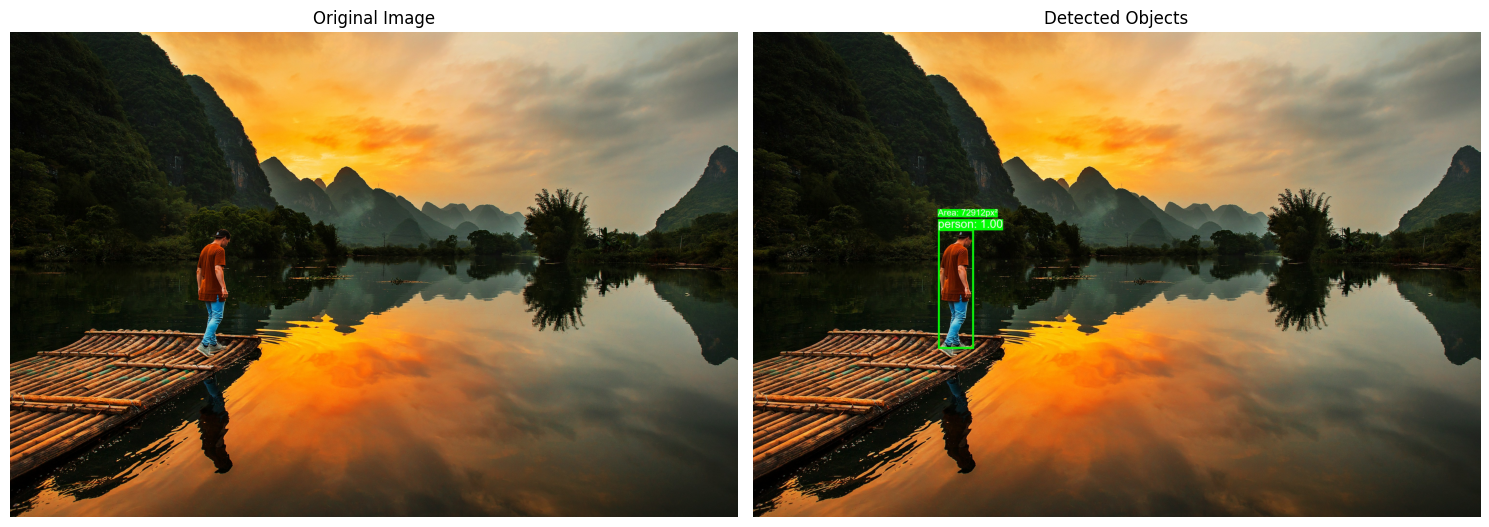

In [22]:
# Display the original and processed images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

original = Image.open(image_path)
detected = Image.open(output_path)

ax1.imshow(original)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(detected)
ax2.set_title("Detected Objects")
ax2.axis("off")

plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (1242132278.py, line 1)